In [ ]:
import mysql.connector
import networkx as nx
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt

# Conexión a la base de datos
def connect_to_db():
    return mysql.connector.connect(
        host="localhost",
        user="root",
        password="123456",
        database="TransaccionesDB"
    )

# Extraer transacciones de la base de datos
def fetch_transactions():
    transactions = []
    with connect_to_db() as db:
        cursor = db.cursor()
        cursor.execute("""
            SELECT transaccion_id, producto_id
            FROM TransaccionProducto
            ORDER BY transaccion_id;
        """)
        
        current_transaction_id = None
        current_items = []
        
        for transaction_id, item_id in cursor.fetchall():
            if transaction_id != current_transaction_id:
                if current_items:
                    transactions.append(current_items)
                current_transaction_id = transaction_id
                current_items = [item_id]
            else:
                current_items.append(item_id)
        
        # Añadir la última transacción
        if current_items:
            transactions.append(current_items)
    
    return transactions




Transacciones: [[1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 29, 30, 31, 32, 33, 34, 57, 58, 59, 60, 61, 62]]


Pregunta 6

In [3]:
from itertools import combinations
from collections import defaultdict

# Solicitar al usuario la cantidad mínima de transacciones para considerar los conjuntos como frecuentes
k = int(input("¿En cuántas transacciones desea que se muestren los conjuntos de productos? "))

# Función para encontrar subconjuntos frecuentes de productos en las transacciones
def frequent_itemsets(transactions, k):
    item_frequency = defaultdict(int)
    
    # Generar combinaciones de productos de cada transacción y contar su frecuencia
    for transaction in transactions:
        # Generar combinaciones de diferentes tamaños (de 2 a 6 elementos)
        for size in range(2, 7):
            for subset in combinations(transaction, size):
                item_frequency[frozenset(subset)] += 1  # Usamos frozenset para que los subconjuntos sean inmutables y puedan ser clave

    # Agrupar subconjuntos por tamaño y filtrar los que cumplen con la frecuencia mínima
    grouped_frequent_sets = defaultdict(list)
    for itemset, count in item_frequency.items():
        if count >= k:  # Solo incluimos los subconjuntos que aparecen al menos 'k' veces
            grouped_frequent_sets[len(itemset)].append(set(itemset))
    
    return grouped_frequent_sets

# Obtener transacciones desde la base de datos (utilizando el código previo de fetch_transactions)
transactions = fetch_transactions()

# Encontrar y mostrar los subconjuntos frecuentes
frequent_sets = frequent_itemsets(transactions, k)
print(f"Subconjuntos frecuentes agrupados por tamaño de conjunto (al menos {k} apariciones):")
for size, sets in sorted(frequent_sets.items()):
    print(f"\nConjuntos de tamaño {size}:")
    for subset in sets:
        print(subset)


Subconjuntos frecuentes agrupados por tamaño de conjunto (al menos 3 apariciones):


Pregunta 7

Edges in Co-occurrence Graph: [(1, 2, {'weight': 2}), (1, 3, {'weight': 2}), (1, 4, {'weight': 2}), (1, 5, {'weight': 2}), (1, 6, {'weight': 2}), (2, 3, {'weight': 2}), (2, 4, {'weight': 2}), (2, 5, {'weight': 2}), (2, 6, {'weight': 2}), (3, 4, {'weight': 2}), (3, 5, {'weight': 2}), (3, 6, {'weight': 2}), (4, 5, {'weight': 2}), (4, 6, {'weight': 2}), (5, 6, {'weight': 2})]


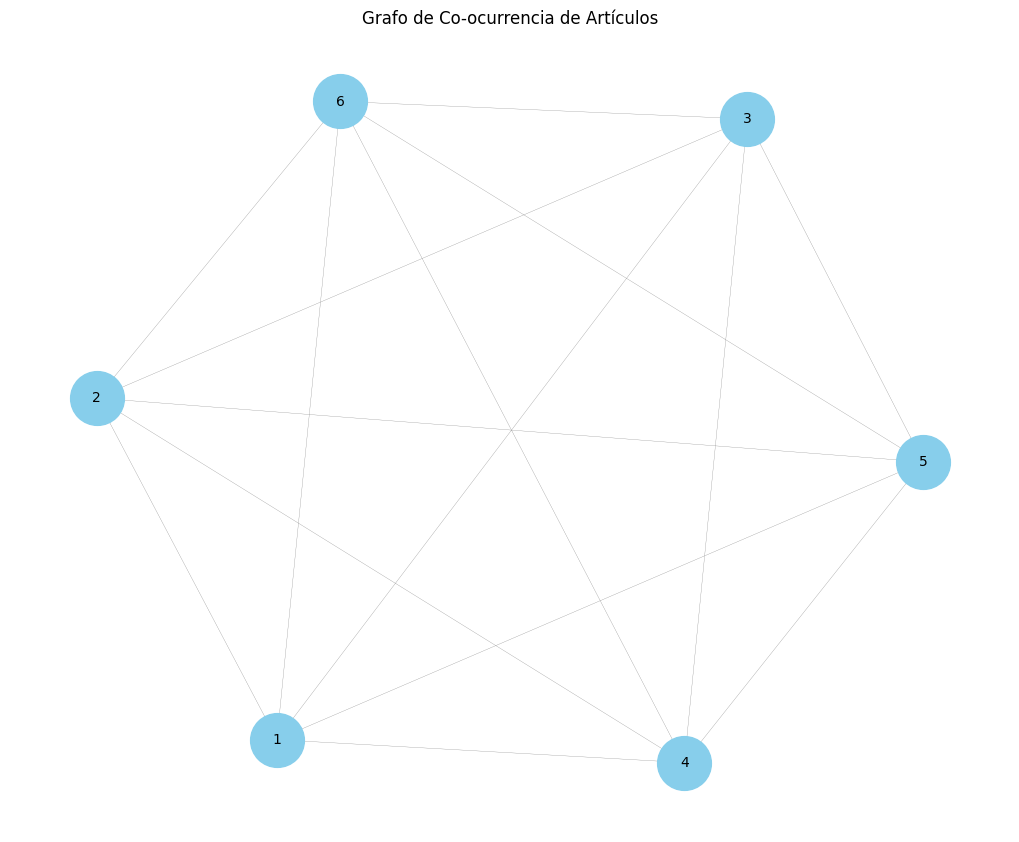

In [5]:
import networkx as nx
from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt

# Función para construir un grafo no dirigido de co-ocurrencia de artículos
def build_cooccurrence_graph(transactions, k):
    co_occurrence_counts = Counter()
    
    # Contar la co-ocurrencia de cada par de artículos
    for transaction in transactions:
        items = set(transaction)
        for subset in combinations(items, 2):  # Generar pares únicos de artículos en cada transacción
            co_occurrence_counts[subset] += 1
    
    # Crear el grafo
    G = nx.Graph()
    
    # Agregar nodos y aristas basados en la frecuencia mínima de co-ocurrencia
    for (item1, item2), count in co_occurrence_counts.items():
        if count >= k:
            G.add_edge(item1, item2, weight=count)  # Agregar arista con peso igual a la frecuencia de co-ocurrencia
    
    return G

# Generar el grafo con k = 2 (co-ocurrencia mínima)
graph = build_cooccurrence_graph(transactions, k=2)
print("Edges in Co-occurrence Graph:", graph.edges(data=True))

# Visualizar el grafo
plt.figure(figsize=(10, 8))
nx.draw(graph, with_labels=True, node_color="skyblue", edge_color="gray", node_size=1500, font_size=10, width=[d['weight'] * 0.1 for (_, _, d) in graph.edges(data=True)])
plt.title("Grafo de Co-ocurrencia de Artículos")
plt.show()


Edges in Co-occurrence Graph: [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6)]


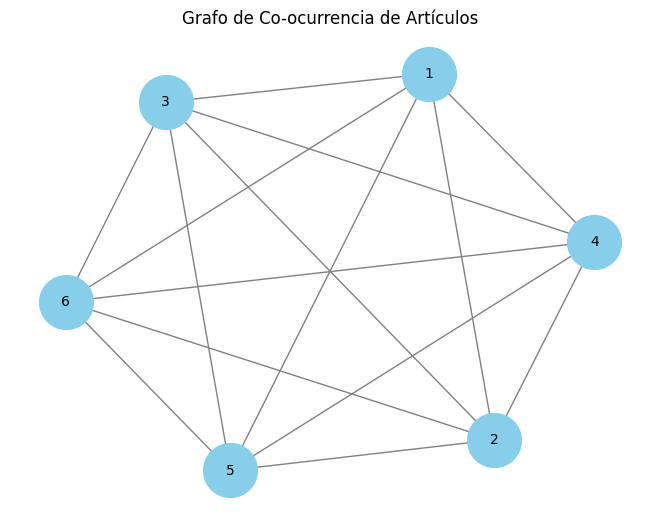

In [ ]:
def build_cooccurrence_graph(transactions, k):
    itemsets = Counter()
    for transaction in transactions:
        items = set(transaction)
        for subset in combinations(items, 2):
            itemsets[subset] += 1
    G = nx.Graph()
    for itemset, count in itemsets.items():
        if count >= k:
            G.add_edge(*itemset)
    return G

# Generar y mostrar el grafo
graph = build_cooccurrence_graph(transactions, k=2)
print("Edges in Co-occurrence Graph:", graph.edges())

# Visualizar el grafo
nx.draw(graph, with_labels=True, node_color="skyblue", edge_color="gray", node_size=1500, font_size=10)
plt.title("Grafo de Co-ocurrencia de Artículos")
plt.show()


Pregunta 8

In [ ]:
from collections import defaultdict
import mysql.connector
import networkx as nx
from itertools import combinations

# Construir el grafo de co-ocurrencia a partir de las transacciones
def build_cooccurrence_graph(transactions, k):
    cooccurrence_counts = defaultdict(int)

    # Contar las co-ocurrencias de cada par de artículos
    for transaction in transactions:
        items = list(transaction)
        for pair in combinations(items, 2):
            cooccurrence_counts[tuple(sorted(pair))] += 1

    # Construir el grafo
    G = nx.Graph()
    for pair, count in cooccurrence_counts.items():
        if count >= k:
            G.add_edge(pair[0], pair[1])

    return G

# Implementación de DFS para encontrar componentes conectados (comunidades)
def dfs(graph, start, visited):
    stack = [start]
    component = set()

    while stack:
        node = stack.pop()
        if node not in visited:
            visited.add(node)
            component.add(node)
            # Agregar nodos adyacentes a la pila si no han sido visitados
            stack.extend(neighbor for neighbor in graph.neighbors(node) if neighbor not in visited)
    
    return component

def find_communities_dfs(graph):
    visited = set()
    communities = []

    for node in graph.nodes():
        if node not in visited:
            component = dfs(graph, node, visited)
            communities.append(component)

    return communities

# Obtener transacciones de la base de datos y construir el grafo
transactions = fetch_transactions()
k = 2  # Umbral mínimo de co-ocurrencia
graph = build_cooccurrence_graph(transactions, k)
communities = find_communities_dfs(graph)

# Mostrar las comunidades
print("Comunidades de artículos que suelen comprarse juntos:")
for i, community in enumerate(communities, start=1):
    print(f"Comunidad {i}: {community}")


Comunidades de artículos que suelen comprarse juntos:
Comunidad 1: {1, 2, 3, 4, 5, 6}
